In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('../input/dataset_191_wine.csv')

In [3]:
X = data.drop('class', axis=1)
y = data['class']

X = (X - X.min()) / (X.max() - X.min())

## K-means++

In [4]:
def calc_rand(clusters, y, n_objects):
    true_vals = np.sum([1 for i in range(n_objects) for j in range(i + 1, n_objects) if 
                 (clusters[i] == clusters[j] and y[i] == y[j] or clusters[i] != clusters[j] and y[i] != y[j])])
    return true_vals / (n_objects * (n_objects - 1) / 2)

def calc_calinski_harabasz(X, clusters, n_objects, n_clusters):
    extra_disp, intra_disp = 0., 0.
    mean = np.mean(X, axis=0)
    for k in range(n_clusters):
        cluster_k = X[clusters == k]
        mean_k = np.mean(cluster_k, axis=0)
        extra_disp += len(cluster_k) * np.sum((mean_k - mean) ** 2)
        intra_disp += np.sum((cluster_k - mean_k) ** 2)
    return (1. if intra_disp == 0. else
            extra_disp * (n_objects - n_clusters) /
            (intra_disp * (n_clusters - 1.)))

In [5]:
best_clusters = []
outer_metric = []
inner_metric = []

for n_clusters in range(2, 11):
    n_objects = X.shape[0]
    print('number of clusters:', n_clusters)
    centroids = []
    distances = np.ones(n_objects) / n_objects
    for _ in range(n_clusters):
        chosen_obj_index = np.argmax(np.random.multinomial(1, [d for d in distances], 1))
        centroids.append(X.loc[chosen_obj_index].values)
        for i in range(n_objects):
            distances[i] = np.min([np.power(np.linalg.norm(X.loc[i] - c), 2) for c in centroids])
        distances = distances / np.sum(distances)
        
    clusters = np.zeros(n_objects)
    for step in range(1000):
        for i in range(n_objects):
            clusters[i] = np.argmin([np.linalg.norm(X.loc[i] - c) for c in centroids])
        old_centroids = centroids.copy()
        for i in range(n_clusters):
            centroids[i] = np.mean(X.values[clusters == i], axis=0)
        deltas = [np.linalg.norm(old - new) for old, new in zip(old_centroids, centroids)]
        if np.sum(deltas) < 1e-6:
            break
            
    if n_clusters == 3:
        best_clusters = clusters.copy()
        
    outer_metric.append(calc_rand(clusters, y, n_objects))
    inner_metric.append(calc_calinski_harabasz(X.values, clusters, n_objects, n_clusters))

number of clusters: 2
number of clusters: 3
number of clusters: 4
number of clusters: 5
number of clusters: 6
number of clusters: 7
number of clusters: 8
number of clusters: 9
number of clusters: 10


[Text(0.5, 1.0, 'Real classes'), Text(0.5, 0, ''), Text(0, 0.5, '')]

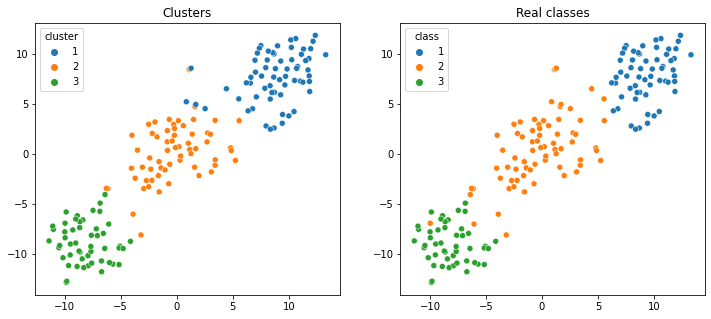

In [6]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded = pd.DataFrame(X_embedded, columns=['x', 'y'])
X_embedded['cluster'] = [int(np.median([y[i] for i in range(n_objects) if best_clusters[i] == c])) for c in best_clusters]
X_embedded['class'] = y

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=X_embedded, x='x', y='y', hue='cluster', ax=ax[0], palette='tab10') \
                .set(title='Clusters', xlabel='', ylabel='')
sns.scatterplot(data=X_embedded, x='x', y='y', hue='class', ax=ax[1], palette='tab10') \
                .set(title='Real classes', xlabel='', ylabel='')

[Text(0.5, 1.0, 'Calinski-Harabasz index')]

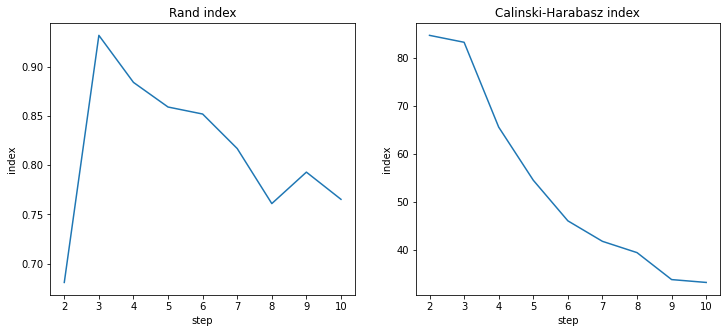

In [7]:
outer_metric_df = pd.DataFrame([(i + 2, val) for i, val in enumerate(outer_metric)], columns=['step', 'index'])
inner_metric_df = pd.DataFrame([(i + 2, val) for i, val in enumerate(inner_metric)], columns=['step', 'index'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(data=outer_metric_df, x='step', y='index', ax=ax[0], palette='tab10') \
                .set(title='Rand index')
sns.lineplot(data=inner_metric_df, x='step', y='index', ax=ax[1], palette='tab10') \
                .set(title='Calinski-Harabasz index')